In [10]:
# libraries
import sys 
sys.path.append("../../models/")
from functions import import_country
import pandas as pd 
import numpy as np 
import os 
import pickle as pkl
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
from matplotlib.colors import to_rgba
import matplotlib.font_manager as font_manager
import matplotlib.patches as patches
import matplotlib.lines as lines
from functions_noscenario import import_country, update_contacts, get_beta

eps   = 1.0 / 3.7
mu    = 1.0 / 2.5
omega = 1.0 / 1.5
chi   = 0.55
f     = 0.35 
countries = ["Italy", "Canada", "Serbia", "Ukraine", "Egypt", "Peru"]

plt.rcParams['axes.linewidth'] = 0.3
plt.rcParams['xtick.major.width'] = 0.3
plt.rcParams['ytick.major.width'] = 0.3
plt.rcParams['xtick.major.size'] = 3
plt.rcParams['ytick.major.size'] = 3
plt.rcParams['xtick.minor.width'] = 0.2
plt.rcParams['ytick.minor.width'] = 0.2
plt.rcParams['xtick.minor.size'] = 1.5
plt.rcParams['ytick.minor.size'] = 1.5

font_dirs = ['../fonts/Bai_Jamjuree/']
font_files = font_manager.findSystemFonts(fontpaths=font_dirs)
font_list = font_manager.createFontList(font_files)
font_manager.fontManager.ttflist.extend(font_list)

plt.rcParams['font.family'] = 'Bai Jamjuree'
plt.rcParams['font.sans-serif'] = 'Bai Jamjuree'

import warnings
warnings.filterwarnings("ignore")

colors = ['#6CC2BD', '#5A809E', '#7C79A2', '#F57D7C', '#FFC1A6', '#FEE4C4']
markers = ["o", "s", "^", "*", "P", "d"]
props = dict(facecolor='grey', alpha=0.1, linewidth=0.3)

start_date = datetime(2021, 1, 1)
end_date   = datetime(2021, 6, 1)
alpha_s    = [0, 0.1, 1, 10, 100]
rs         = [1.3]

In [11]:
def import_boxplot(country, rV, cases=False, real=False):
    
    vaccination_strategies = ["old_first", "homogeneous", "20-49_first"]

    files = os.listdir("../../output/runs_fullrestrictions/")
    files = [file for file in files if country in file and "rV" + str(rV) in file]
    if cases == True:
        files = [file for file in files if "cases" in file]
    else:
        files = [file for file in files if "cases" not in file]

    if real == True:
        vaccination_strategies = ["real"]
        files = [file for file in files if "real" in file]
    else:
        files = [file for file in files if "real" not in file]
        
        
    # initialize solutions
    data          = dict()
    data[country] = dict()
    for vaccination_strategy in vaccination_strategies:
        data[country][vaccination_strategy] = dict()
        for r in rs:
            data[country][vaccination_strategy][r] = dict()
            for alpha in alpha_s:
                data[country][vaccination_strategy][r][alpha] = []

    for file in files:
        with open("../../output/runs_fullrestrictions/" + file, "rb") as file:  
            data_temp = pkl.load(file)
            for vaccination_strategy in vaccination_strategies:
                for r in rs:
                    for alpha in alpha_s:
                        for el in data_temp[country][vaccination_strategy][r][alpha]:
                            data[country][vaccination_strategy][r][alpha].append(el)
                            
    return data

In [12]:
data_dict = {}
for country in countries:
    
    data_dict[country] = {}
    
    # import country
    country_dict = import_country(country, "../../../data/countries/")
    C = update_contacts(country_dict, datetime(2020, 9, 1))

    # import params
    params = []
    files  = os.listdir("../../output/posterior/")
    files  = [file for file in files if country in file]
    params_sampled = []
    for file in files:
        if params_sampled == []:
            params_sampled = np.load("../../output/posterior/" + file, allow_pickle=True)["arr_0"]
        else: 
            params = np.load("../../output/posterior/" + file, allow_pickle=True)["arr_0"]
            params_sampled = np.concatenate((params_sampled, params))

    R0_sampled     = np.array([p[0] for p in params_sampled]) 
    Delta_sampled  = np.array([p[1] for p in params_sampled])
    i0_sampled     = np.array([p[2] for p in params_sampled]) 
    i0_sampled     = i0_sampled * 100000
    deaths_sampled = np.array([p[3] for p in params_sampled]) 
    ics            = np.array([p[4].sum(axis=0) for p in params_sampled])
    betas_sampled  = np.array([get_beta(R0, mu, chi, omega, f, C, country_dict["Nk"]) for R0 in R0_sampled])
  
    date = start_date
    eigs = []
    while date <= end_date:
        C = update_contacts(country_dict, date)
        eigs.append(np.linalg.eigvals(C).real.max())
        date += timedelta(days=1)
        
    C_bas = update_contacts(country_dict, date, baseline=True)
    eig_bas = np.linalg.eigvals(C_bas).real.max()
    eigs_fr = np.array(eigs) / eig_bas
    
    data_dict[country]["R0_sampled"] = R0_sampled
    data_dict[country]["Delta_sampled"] = Delta_sampled
    data_dict[country]["i0_sampled"] = i0_sampled
    data_dict[country]["ics"] = ics
    data_dict[country]["betas_sampled"] = betas_sampled
    data_dict[country]["eigs"] = np.array(eigs)
    data_dict[country]["eigs_fr"] = np.array(eigs_fr)

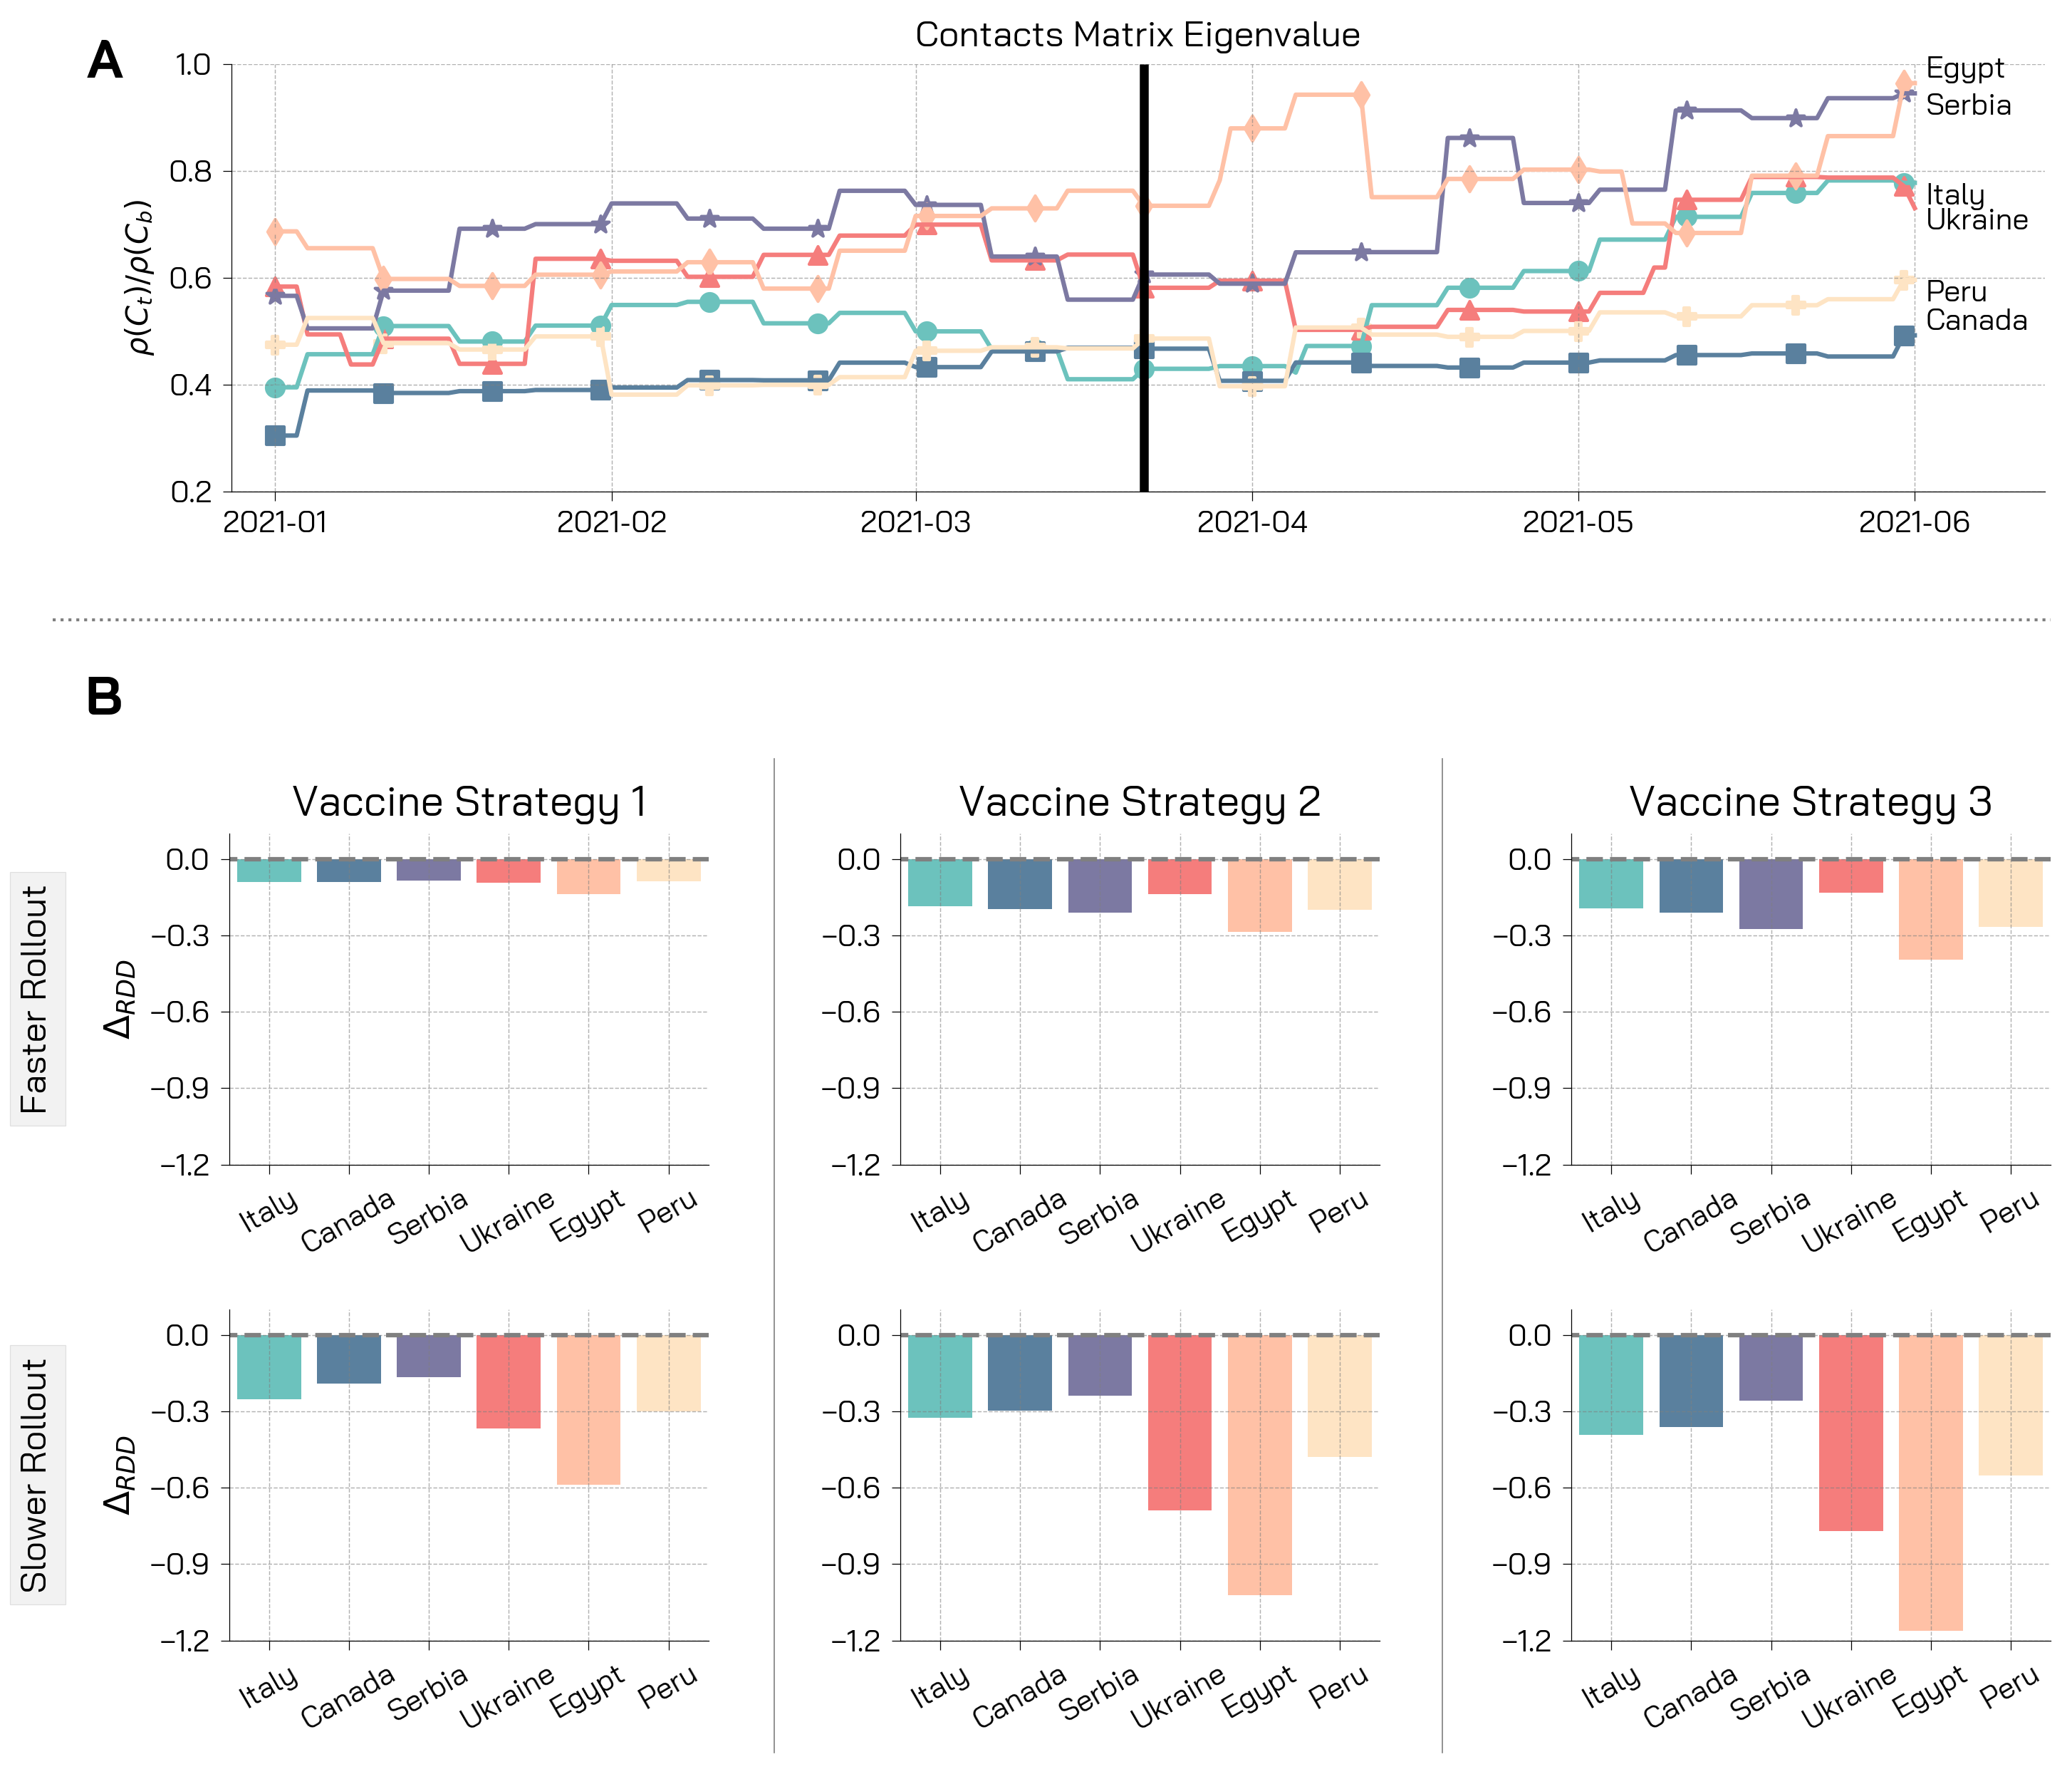

In [13]:
colors = ['#6CC2BD', '#5A809E', '#7C79A2', '#F57D7C', '#FFC1A6', '#FEE4C4']

dates = []
date = start_date
while date <= end_date:
    dates.append(date)
    date += timedelta(days=1)

# create axes list
fig = plt.figure(figsize=(11., 5.), dpi=300)
num_rows, num_cols       = 2, 3
row_height, space_height = 3, 0
num_sep_rows = lambda x: int((x - 1) / 2)
grid = (row_height * num_rows + space_height * num_sep_rows(num_rows), num_cols)
ax_list = []
for ind_row in range(num_rows):
    for ind_col in range(num_cols):
        grid_row = row_height * ind_row + space_height * num_sep_rows(ind_row + 1)
        grid_col = ind_col
        ax_list += [plt.subplot2grid(grid, (grid_row, grid_col), rowspan=row_height)]
plt.subplots_adjust(hspace=10.5, wspace=0.4)


# plot
i = 0
k = 0
for country in ["Italy", "Canada", "Serbia", "Ukraine", "Egypt", "Peru"]:

    data_025_deaths = import_boxplot(country, 0.25 / 100, False)
    data_01_deaths  = import_boxplot(country, 1.0  / 100, False)
    
    data_025_deaths = import_boxplot(country, 0.25 / 100, False)
    data_01_deaths  = import_boxplot(country, 1.0  / 100, False)
    
    delta1 = (np.median(data_01_deaths[country]["old_first"][1.3][alpha_s[-1]]) - 
               np.median(data_01_deaths[country]["old_first"][1.3][alpha_s[0]]))
    
    delta2 = (np.median(data_01_deaths[country]["homogeneous"][1.3][alpha_s[-1]]) - 
               np.median(data_01_deaths[country]["homogeneous"][1.3][alpha_s[0]]))

    delta3 = (np.median(data_01_deaths[country]["20-49_first"][1.3][alpha_s[-1]]) - 
               np.median(data_01_deaths[country]["20-49_first"][1.3][alpha_s[0]]))
    
    
    ax_list[0].bar([k], [delta1], color=colors[k])
    ax_list[1].bar([k], [delta2], color=colors[k])
    ax_list[2].bar([k], [delta3], color=colors[k])
    
    delta1 = (np.median(data_025_deaths[country]["old_first"][1.3][alpha_s[-1]]) - 
               np.median(data_025_deaths[country]["old_first"][1.3][alpha_s[0]]))
    
    delta2 = (np.median(data_025_deaths[country]["homogeneous"][1.3][alpha_s[-1]]) - 
               np.median(data_025_deaths[country]["homogeneous"][1.3][alpha_s[0]]))

    delta3 = (np.median(data_025_deaths[country]["20-49_first"][1.3][alpha_s[-1]]) - 
               np.median(data_025_deaths[country]["20-49_first"][1.3][alpha_s[0]]))
    
    
    ax_list[3].bar([k], [delta1], color=colors[k])
    ax_list[4].bar([k], [delta2], color=colors[k])
    ax_list[5].bar([k], [delta3], color=colors[k])
    
    k += 1
    i += 1
    
for ax in ax_list:
    ax.set_xticks([0, 1, 2, 3, 4, 5])
    ax.tick_params(axis="y", labelsize=10)
    ax.set_xticklabels(["Italy", "Canada", "Serbia", "Ukraine", "Egypt", "Peru"], rotation=30, fontsize=10)
    ax.grid(color='grey', linestyle='--', linewidth=0.35, alpha=0.6, axis="both")
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.hlines(0, -0.9, 5.5, linestyle="--", color="gray")
    ax.yaxis.set_major_locator(plt.MaxNLocator(5))
    ax.set_xlim(xmin=-0.5, xmax=5.5)
    
ax_list[0].set_title("Vaccine Strategy 1", fontsize=14)
ax_list[1].set_title("Vaccine Strategy 2", fontsize=14)
ax_list[2].set_title("Vaccine Strategy 3", fontsize=14)

ax_list[0].annotate("Faster Rollout", xy=(-0.4,0.5), xycoords='axes fraction', bbox=props, rotation=90, fontsize=12, va='center', ha='center')
ax_list[3].annotate("Slower Rollout", xy=(-0.4,0.5), xycoords='axes fraction', bbox=props, rotation=90, fontsize=12, va='center', ha='center')
ax_list[0].set_ylabel("$\\Delta_{RDD}$", fontsize=12)
ax_list[3].set_ylabel("$\\Delta_{RDD}$", fontsize=12)

for ax in [ax_list[0], ax_list[1], ax_list[2], ax_list[3], ax_list[4], ax_list[5]]:
    ax.set_ylim(-1.2, 0.1)
   
fig.add_artist(lines.Line2D([0.357, 0.357], [0.02, 0.95], linestyle="-", color="gray", linewidth=0.4))
fig.add_artist(lines.Line2D([0.641, 0.641], [0.02, 0.95], linestyle="-", color="gray", linewidth=0.4))

ins4 = fig.add_axes([0.126, 1.2, 0.223*3.46, 0.4])

i = 0
countries = ['Italy', 'Canada', 'Ukraine', 'Serbia', 'Peru', 'Egypt']
colors = ['#6CC2BD', '#5A809E', '#F57D7C', '#7C79A2', '#FEE4C4', '#FFC1A6']
for country in countries:
    
    country_dict = import_country(country, "../../../data/countries/")
    ics            = data_dict[country]["ics"]
    betas_sampled  = data_dict[country]["betas_sampled"]
    eigs_fr        = data_dict[country]["eigs_fr"]
    ins4.plot(dates, eigs_fr, color=colors[i])
    x = np.arange(0, len(eigs_fr), 10)
    ins4.scatter(np.array(dates)[x], eigs_fr[x], marker=markers[i], color=colors[i])
    
    if country == "Peru":
        ins4.text(datetime(2021, 6, 2), eigs_fr[-1], country, va="top")
    elif country == "Egypt":
        ins4.text(datetime(2021, 6, 2), eigs_fr[-1], country, va="bottom")
    elif country == "Serbia":
        ins4.text(datetime(2021, 6, 2), eigs_fr[-1], country, va="top")
    elif country == "Italy":
        ins4.text(datetime(2021, 6, 2), eigs_fr[-1], country, va="top")
    elif country == "Ukraine":
        ins4.text(datetime(2021, 6, 2), eigs_fr[-1], country, va="top")
    elif country == "Canada":
        ins4.text(datetime(2021, 6, 2), eigs_fr[-1], country, va="bottom")
    else:
        ins4.text(datetime(2021, 6, 2), eigs_fr[-1], country)
    i += 1
    
ins4.set_ylabel("$\\rho(C_t) / \\rho(C_{b})$")
ins4.set_title("Contacts Matrix Eigenvalue")
ins4.vlines(datetime(2021, 3, 22), 0, 1, color="black", zorder=100, linewidth=3)

ins4.set_xlim(datetime(2020, 12, 28), datetime(2021, 6, 13))
ins4.set_ylim(0.2, 1.0)

for ins in [ins4]:
    ins.grid(color='grey', linestyle='--', linewidth=0.35, alpha=0.6, axis="both")
    ins.spines['top'].set_visible(False)
    ins.spines['right'].set_visible(False)
    

fig.add_artist(lines.Line2D([0.05, 0.9], [1.08, 1.08], linestyle="dotted", color="gray", linewidth=1))
ins4.annotate("A", xy=(-0.08, 1.), xycoords='axes fraction', fontsize=18, va='center', ha='left', weight="bold")
ax_list[0].annotate("B", xy=(-0.30, 1.4), xycoords='axes fraction', fontsize=18, va='center', ha='left', weight="bold")

plt.savefig("./SM_img/calibrated_model_fullrestrictions.pdf", bbox_inches="tight")